# Compare DBTL2 and DBTL3 results
In DBTL2 we made ART-recommended CRISPRi combinations. However, we discovered that many of them did not have high dCas9 expression and therefore had low target inhibition. In DBTL3, David updated the dCas9 system to prevent recombination-driven dCas9 silencing, and then made the exact same strains as in DBTL2. 

We'd like to use the data from DBTL3 along with the data from DBTL0 and DBTL1 in order to make predictions for a future cycle. However, it is unclear how to integrate the new data given that the dCas9 system is new.

Some questions:

- How good is the titer correlation between cycles?
- How good is the proteomics correlation between cycles?


In [1]:
import edd_utils as eddu
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import random
random.seed(1)
from sklearn.metrics import mean_absolute_error, r2_score

Import processed data

In [2]:
df = pd.read_csv('./ml/data/unnormalized_proteomics_pivot.csv', index_col=0)

In [3]:
df

,MM_1762,PP_0001,PP_0002,PP_0003,PP_0004,PP_0005,PP_0006,PP_0009,PP_0010,PP_0011,...,PP_5416,PP_5417,PP_5418,SPy_1046,YNR043W,aacC1,b4055 JW4015,mvaS,neo,isoprenol
line_name_rep_cycle,,,,,,,,,,,,,,,,,,,,,
Control-R10_c1,204555498.0,4191160.00,1726479.00,3373951.00,2173503.20,738448.20,9799845.60,3990000.00,7383747.00,18246467.00,...,7783568.00,26338335.00,0.00,28115139.40,582841585.4,3.540011e+08,78695480.00,1.748806e+08,611368325.0,176.13507
Control-R11_c1,225083958.1,2954944.60,1519673.10,2999362.20,2068667.90,745762.90,11322391.80,3840000.00,6756559.10,21568347.80,...,8560711.10,29120542.00,22439.40,24151481.40,628324289.0,3.715957e+08,89522940.50,1.855450e+08,583198798.1,192.63713
Control-R12_c1,226726387.0,4756032.40,891103.00,3438064.90,2201048.00,1559719.40,10431480.00,3490000.00,6141182.00,20956471.00,...,8744373.00,26427577.00,6920000.00,26008612.70,604150115.0,3.712542e+08,66224677.00,1.838732e+08,622874642.0,202.70480
Control-R13_c1,200667947.6,4025175.40,2821506.40,2777374.50,2254175.60,933420.60,10625799.20,4560000.00,7289281.70,21456500.20,...,9898680.20,28681508.40,21364.80,18057997.40,598017284.4,3.228457e+08,66120646.40,1.635552e+08,493564402.8,123.84653
Control-R14_c1,197817740.0,4954802.00,1928740.00,3060918.70,1873130.60,820983.00,10869912.00,4270000.00,5371024.00,20988699.10,...,9738552.00,24870124.00,45745.40,19880408.70,617297176.0,3.000795e+08,72990757.00,1.498090e+08,596946095.0,177.18560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_5419-R2_c1,178768404.0,4131963.00,71770.00,1760021.40,984214.40,1492928.00,6667854.10,1900000.00,4177118.00,17071547.00,...,6189417.00,24107160.00,28708.00,803824.00,573320625.0,1.128065e+07,89442492.00,1.830121e+08,555565357.0,370.25140
PP_5419-R3_c1,183746539.3,4255756.50,553067.80,1974287.30,1515129.60,2234677.10,6523522.30,2310000.00,7489820.90,16438592.60,...,5855244.50,21230302.70,29217.40,818087.20,553088857.8,3.242957e+06,79550335.50,1.897306e+08,594267176.7,412.20373
PP_5420-R1_c1,120504898.3,3028443.34,498753.70,1467967.58,402468.14,1433527.48,1677480.10,850904.94,2992267.08,4802645.40,...,4832609.94,17318943.76,272428.88,238334.18,292583031.3,9.634786e+04,47392281.16,1.269587e+07,683034233.3,84.91467


In [4]:
df = df.dropna(axis = 0, how = 'any', subset=['isoprenol'])
df = df.dropna(axis = 1, how = 'any')

df

,MM_1762,PP_0001,PP_0002,PP_0003,PP_0004,PP_0005,PP_0006,PP_0009,PP_0010,PP_0011,...,PP_5416,PP_5417,PP_5418,SPy_1046,YNR043W,aacC1,b4055 JW4015,mvaS,neo,isoprenol
line_name_rep_cycle,,,,,,,,,,,,,,,,,,,,,
Control-R10_c1,204555498.0,4191160.00,1726479.00,3373951.00,2173503.20,738448.20,9799845.60,3990000.00,7383747.00,18246467.00,...,7783568.00,26338335.00,0.00,28115139.40,582841585.4,3.540011e+08,78695480.00,1.748806e+08,611368325.0,176.13507
Control-R11_c1,225083958.1,2954944.60,1519673.10,2999362.20,2068667.90,745762.90,11322391.80,3840000.00,6756559.10,21568347.80,...,8560711.10,29120542.00,22439.40,24151481.40,628324289.0,3.715957e+08,89522940.50,1.855450e+08,583198798.1,192.63713
Control-R12_c1,226726387.0,4756032.40,891103.00,3438064.90,2201048.00,1559719.40,10431480.00,3490000.00,6141182.00,20956471.00,...,8744373.00,26427577.00,6920000.00,26008612.70,604150115.0,3.712542e+08,66224677.00,1.838732e+08,622874642.0,202.70480
Control-R13_c1,200667947.6,4025175.40,2821506.40,2777374.50,2254175.60,933420.60,10625799.20,4560000.00,7289281.70,21456500.20,...,9898680.20,28681508.40,21364.80,18057997.40,598017284.4,3.228457e+08,66120646.40,1.635552e+08,493564402.8,123.84653
Control-R14_c1,197817740.0,4954802.00,1928740.00,3060918.70,1873130.60,820983.00,10869912.00,4270000.00,5371024.00,20988699.10,...,9738552.00,24870124.00,45745.40,19880408.70,617297176.0,3.000795e+08,72990757.00,1.498090e+08,596946095.0,177.18560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_5419-R2_c1,178768404.0,4131963.00,71770.00,1760021.40,984214.40,1492928.00,6667854.10,1900000.00,4177118.00,17071547.00,...,6189417.00,24107160.00,28708.00,803824.00,573320625.0,1.128065e+07,89442492.00,1.830121e+08,555565357.0,370.25140
PP_5419-R3_c1,183746539.3,4255756.50,553067.80,1974287.30,1515129.60,2234677.10,6523522.30,2310000.00,7489820.90,16438592.60,...,5855244.50,21230302.70,29217.40,818087.20,553088857.8,3.242957e+06,79550335.50,1.897306e+08,594267176.7,412.20373
PP_5420-R1_c1,120504898.3,3028443.34,498753.70,1467967.58,402468.14,1433527.48,1677480.10,850904.94,2992267.08,4802645.40,...,4832609.94,17318943.76,272428.88,238334.18,292583031.3,9.634786e+04,47392281.16,1.269587e+07,683034233.3,84.91467


In [5]:
df_mean = df.copy()
df_mean['cycle'] = [x[-1] for x in df_mean.index.values]
df_mean['cycle'].value_counts()
# omics_mean['line_name'] = omics_mean.apply(lambda x: x.index.values.split('-')[0], axis = 1)
df_mean['line_name'] = [f"{x.split('-')[0]}_c{x[-1]}" for x in df_mean.index.values]
df_mean['is_control'] = ['ontrol' in x for x in df_mean['line_name']]
df_mean.loc[df_mean['is_control'], 'line_name'] = df_mean.loc[
    df_mean['is_control'], 'line_name'].apply(lambda x: f'Control_c{x[-1]}')
df_mean = df_mean.drop(['cycle', 'is_control'], axis = 1)

df_mean = df_mean.groupby('line_name').mean()
df_mean.shape

(297, 1899)

In [6]:
protein_measurements = df.columns[:-1]
protein_measurements.shape

(1898,)

In [7]:
omics_index = df.index.values
cycle_label = [int(x[-1]) for x in omics_index]
num_grna = [x.count('PP') for x in omics_index]
is_control = [1 if 'ontrol' in x else 0 for x in omics_index]

In [8]:
df_mean['is_control'] = [1 if 'ontrol' in x else 0 for x in df_mean.index.values]
df_mean['cycle'] = [int(x[-1]) for x in df_mean.index.values]
df_mean['line_name'] = [x[:-3] for x in df_mean.index.values]
df_mean

,MM_1762,PP_0001,PP_0002,PP_0003,PP_0004,PP_0005,PP_0006,PP_0009,PP_0010,PP_0011,...,SPy_1046,YNR043W,aacC1,b4055 JW4015,mvaS,neo,isoprenol,is_control,cycle,line_name
line_name,,,,,,,,,,,,,,,,,,,,,
Control_c1,1.816068e+08,4.190752e+06,1.785088e+06,3.227803e+06,2.136764e+06,1.010645e+06,9.738859e+06,3.353180e+06,5.824796e+06,1.891542e+07,...,1.936025e+07,5.458132e+08,3.152285e+08,7.314013e+07,1.592231e+08,5.326017e+08,169.765796,1,1,Control
Control_c2,8.746541e+07,2.354989e+06,1.087657e+06,1.622490e+06,1.109634e+06,4.990649e+05,6.702403e+06,2.732500e+06,3.203842e+06,9.231990e+06,...,8.654428e+06,2.910999e+08,1.408781e+08,6.912507e+07,7.461423e+07,3.511994e+08,154.402367,1,2,Control
Control_c3,3.820415e+07,6.402451e+05,2.097430e+05,3.686189e+05,4.174454e+05,1.924163e+05,2.723007e+06,1.238665e+06,9.368502e+05,3.421338e+06,...,3.671387e+06,1.219371e+08,5.477344e+07,3.157739e+07,3.448815e+07,1.595792e+08,156.733342,1,3,Control
Control_c4,8.321961e+07,1.517087e+06,9.052843e+05,1.490307e+06,1.191411e+06,4.633126e+05,6.303328e+06,2.405025e+06,4.972211e+06,7.083371e+06,...,4.161315e+06,3.313943e+08,6.767437e+07,1.017183e+08,4.981897e+07,2.921924e+08,168.831417,1,4,Control
PP_0001_c1,8.657934e+07,2.131174e+05,1.854384e+06,1.911202e+06,1.073568e+06,7.026901e+05,8.374987e+06,2.907013e+06,3.367204e+06,1.279317e+07,...,8.202380e+06,3.281497e+08,2.545276e+08,5.279726e+07,5.876666e+07,2.813908e+08,58.026153,0,1,PP_0001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PP_5335_c1,1.775453e+08,4.306747e+06,6.094130e+05,2.466402e+06,1.961340e+06,1.141574e+06,8.524237e+06,2.781136e+06,4.959964e+06,9.198233e+06,...,6.853411e+05,5.304307e+08,2.947028e+08,6.947516e+07,1.433816e+08,5.944482e+08,214.305777,0,1,PP_5335
PP_5416_c1,1.559369e+08,3.073925e+06,8.808762e+05,1.127563e+06,5.241560e+05,9.976023e+05,3.885327e+06,1.726661e+06,1.856776e+06,6.813796e+06,...,1.563958e+05,6.171279e+08,8.988677e+05,4.458959e+07,1.382715e+08,4.164763e+08,152.724000,0,1,PP_5416
PP_5417_c1,1.833151e+08,5.080531e+06,8.639931e+05,2.711307e+06,2.166791e+06,1.278990e+06,8.913003e+06,3.210000e+06,4.489501e+06,1.216184e+07,...,3.409870e+06,5.028226e+08,1.743625e+08,7.446149e+07,1.324022e+08,5.987893e+08,202.526733,0,1,PP_5417


Get unique line names in cycle 2 and 3

In [9]:
cycle3_lines = set(df_mean.loc[df_mean['cycle'] == 3, 'line_name'])
cycle4_lines = set(df_mean.loc[df_mean['cycle'] == 4, 'line_name'])
shared_lines = cycle3_lines.intersection(cycle4_lines)
shared_lines

{'Control',
 'PP_0368_PP_0528_PP_4191',
 'PP_0368_PP_0812',
 'PP_0368_PP_0813',
 'PP_0368_PP_1769',
 'PP_0368_PP_4189',
 'PP_0437_PP_0751_PP_4191',
 'PP_0437_PP_0814',
 'PP_0437_PP_1769',
 'PP_0437_PP_4189',
 'PP_0528_PP_0751_PP_0815_PP_1317',
 'PP_0528_PP_0751_PP_4191',
 'PP_0528_PP_0812_PP_4191',
 'PP_0528_PP_0813_PP_0815_PP_1317',
 'PP_0528_PP_0813_PP_4191',
 'PP_0528_PP_0814_PP_0815_PP_1317',
 'PP_0528_PP_0814_PP_4191',
 'PP_0528_PP_0815_PP_1317',
 'PP_0528_PP_0815_PP_1317_PP_4191',
 'PP_0528_PP_0815_PP_4191',
 'PP_0528_PP_1769_PP_4191',
 'PP_0528_PP_4120_PP_4191',
 'PP_0751_PP_0813',
 'PP_0751_PP_0813_PP_4189',
 'PP_0751_PP_0813_PP_4191',
 'PP_0751_PP_0814',
 'PP_0751_PP_0814_PP_1769',
 'PP_0751_PP_0815_PP_1317',
 'PP_0751_PP_1769_PP_4189',
 'PP_0751_PP_4189',
 'PP_0812_PP_0814',
 'PP_0812_PP_0815_PP_1317',
 'PP_0812_PP_1769',
 'PP_0812_PP_4189',
 'PP_0813_PP_0814',
 'PP_0813_PP_0814_PP_1769',
 'PP_0813_PP_0815_PP_1317',
 'PP_0813_PP_1769',
 'PP_0813_PP_1769_PP_4189',
 'PP_0813_PP

Transpose dataframe to make scatterplots

In [10]:
df_mean['line_name_cycle'] = df_mean.index.values
df_mean.loc[(df_mean['cycle'].isin([3, 4])) &
           (df_mean['line_name'].isin(shared_lines))].transpose()

line_name,Control_c3,Control_c4,PP_0368_PP_0528_PP_4191_c3,PP_0368_PP_0528_PP_4191_c4,PP_0368_PP_0812_c3,PP_0368_PP_0812_c4,PP_0368_PP_0813_c3,PP_0368_PP_0813_c4,PP_0368_PP_1769_c3,PP_0368_PP_1769_c4,...,PP_1769_PP_2136_c3,PP_1769_PP_2136_c4,PP_1769_PP_4189_c3,PP_1769_PP_4189_c4,PP_1769_PP_4192_c3,PP_1769_PP_4192_c4,PP_2136_PP_4189_c3,PP_2136_PP_4189_c4,PP_4189_PP_4192_c3,PP_4189_PP_4192_c4
MM_1762,38204150.221667,83219612.3,43669043.116667,100354938.73,38941738.666667,110314091.833333,46782006.566667,110430574.566667,34917971.933333,87967478.033333,...,43437108.833333,98768111.733333,40507713.28,63849397.533333,41728396.236667,86158643.556667,31909137.933333,70220781.14,42991972.783333,87192356.323333
PP_0001,640245.1,1517087.421667,721368.306667,1628119.63,258498.1,2478470.456667,409203.9,2382664.813333,451373.266667,1597140.133333,...,413689.633333,2484474.866667,862387.723333,1974477.166667,568282.516667,1188981.106667,615518.516667,1646963.716667,563954.206667,2229526.306667
PP_0002,209742.989167,905284.286667,199016.733333,1240878.916667,186208.6,832291.376667,161395.6,1001189.533333,121742.0,1018412.7,...,162405.233333,811486.866667,254807.996667,907798.666667,132407.85,1123578.313333,254820.05,1257701.083333,140556.836667,695436.813333
PP_0003,368618.931667,1490307.400833,449581.593333,1366942.966667,197893.2,1698528.916667,325920.266667,1721958.83,263965.066667,1453186.966667,...,346062.3,1778996.066667,629425.103333,1061247.3,366911.513333,1284097.906667,283413.216667,1439922.136667,300471.12,1206363.986667
PP_0004,417445.41,1191410.739167,520783.306667,1191587.306667,254951.266667,1011669.586667,522886.7,985798.373333,314637.533333,965950.833333,...,382249.566667,1150222.8,640563.553333,1231770.833333,436598.883333,664096.673333,359375.683333,1053727.393333,322896.443333,882527.096667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
isoprenol,156.733342,168.831417,328.502033,337.627467,312.156633,364.611833,394.4247,355.079267,190.439533,241.181067,...,198.618967,226.606467,335.997067,152.213467,268.570067,233.983067,183.626,253.994067,297.562933,316.073733
is_control,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cycle,3,4,3,4,3,4,3,4,3,4,...,3,4,3,4,3,4,3,4,3,4
line_name,Control,Control,PP_0368_PP_0528_PP_4191,PP_0368_PP_0528_PP_4191,PP_0368_PP_0812,PP_0368_PP_0812,PP_0368_PP_0813,PP_0368_PP_0813,PP_0368_PP_1769,PP_0368_PP_1769,...,PP_1769_PP_2136,PP_1769_PP_2136,PP_1769_PP_4189,PP_1769_PP_4189,PP_1769_PP_4192,PP_1769_PP_4192,PP_2136_PP_4189,PP_2136_PP_4189,PP_4189_PP_4192,PP_4189_PP_4192


melt and merge dataframes to make scatterplots

In [11]:
protein_measurements.union(['line_name'])
# indx.union([20])


Index(['MM_1762', 'PP_0001', 'PP_0002', 'PP_0003', 'PP_0004', 'PP_0005',
       'PP_0006', 'PP_0009', 'PP_0010', 'PP_0011',
       ...
       'PP_5416', 'PP_5417', 'PP_5418', 'SPy_1046', 'YNR043W', 'aacC1',
       'b4055 JW4015', 'line_name', 'mvaS', 'neo'],
      dtype='object', length=1899)

In [12]:
titer_df_cycle3_melt = df_mean.loc[df_mean['cycle'] == 3, ['line_name','isoprenol']].melt(id_vars = 'line_name', value_vars = 'isoprenol', var_name = 'measurement', value_name = 'titer3').set_index(['line_name', 'measurement'])
titer_df_cycle4_melt = df_mean.loc[df_mean['cycle'] == 4, ['line_name','isoprenol']].melt(id_vars = 'line_name', value_vars = 'isoprenol', var_name = 'measurement', value_name = 'titer4').set_index(['line_name', 'measurement'])
titer_df_merge = titer_df_cycle3_melt.merge(titer_df_cycle4_melt, on = ['line_name', 'measurement'], how = 'inner').reset_index()
titer_df_merge

,line_name,measurement,titer3,titer4
0,Control,isoprenol,156.733342,168.831417
1,PP_0368_PP_0528_PP_4191,isoprenol,328.502033,337.627467
2,PP_0368_PP_0812,isoprenol,312.156633,364.611833
3,PP_0368_PP_0813,isoprenol,394.424700,355.079267
4,PP_0368_PP_1769,isoprenol,190.439533,241.181067
5,PP_0368_PP_4189,isoprenol,342.346733,335.353533
6,PP_0437_PP_0751_PP_4191,isoprenol,352.411767,234.237167
7,PP_0437_PP_0814,isoprenol,305.798300,306.253367
8,PP_0437_PP_1769,isoprenol,233.721367,183.288167
9,PP_0437_PP_4189,isoprenol,339.156567,290.934133


In [13]:
df_cycle3_melt = df_mean.loc[df_mean['cycle'] == 3, protein_measurements.union(['line_name'])].melt(id_vars = 'line_name', value_vars = protein_measurements, var_name = 'protein', value_name = 'value3').set_index(['line_name', 'protein'])
df_cycle4_melt = df_mean.loc[df_mean['cycle'] == 4, protein_measurements.union(['line_name'])].melt(id_vars = 'line_name', value_vars = protein_measurements, var_name = 'protein', value_name = 'value4').set_index(['line_name', 'protein'])
df_merge = df_cycle3_melt.merge(df_cycle4_melt, on = ['line_name', 'protein'], how = 'inner').reset_index()
df_merge['log1p_value3'] = np.log10(1+df_merge['value3'])
df_merge['log1p_value4'] = np.log10(1+df_merge['value4'])
df_merge

,line_name,protein,value3,value4,log1p_value3,log1p_value4
0,Control,MM_1762,3.820415e+07,8.321961e+07,7.582111,7.920226
1,PP_0368_PP_0528_PP_4191,MM_1762,4.366904e+07,1.003549e+08,7.640174,8.001539
2,PP_0368_PP_0812,MM_1762,3.894174e+07,1.103141e+08,7.590415,8.042631
3,PP_0368_PP_0813,MM_1762,4.678201e+07,1.104306e+08,7.670079,8.043089
4,PP_0368_PP_1769,MM_1762,3.491797e+07,8.796748e+07,7.543049,7.944322
...,...,...,...,...,...,...
96793,PP_1769_PP_2136,neo,1.531405e+08,3.702353e+08,8.185090,8.568478
96794,PP_1769_PP_4189,neo,1.327603e+08,3.000486e+08,8.123068,8.477192
96795,PP_1769_PP_4192,neo,1.656470e+08,3.695533e+08,8.219184,8.567677
96796,PP_2136_PP_4189,neo,1.193426e+08,2.589603e+08,8.076795,8.413233


Add protein as percent of all counts for each line

In [14]:
for ln in df_merge['line_name'].unique():
    ln_idx = df_merge['line_name'] == ln
    df_merge.loc[ln_idx, 'pct3'] = 100*df_merge.loc[ln_idx, 'value3']/df_merge.loc[ln_idx,'value3'].sum()
    df_merge.loc[ln_idx, 'pct4'] = 100*df_merge.loc[ln_idx, 'value4']/df_merge.loc[ln_idx,'value4'].sum()
df_merge.head(3)                                                                               

,line_name,protein,value3,value4,log1p_value3,log1p_value4,pct3,pct4
0,Control,MM_1762,3.820415e+07,8.321961e+07,7.582111,7.920226,0.822050,0.777471
1,PP_0368_PP_0528_PP_4191,MM_1762,4.366904e+07,1.003549e+08,7.640174,8.001539,0.966146,1.005596
2,PP_0368_PP_0812,MM_1762,3.894174e+07,1.103141e+08,7.590415,8.042631,0.928073,0.975727


In [15]:
df_merge['protein'].unique()[:15]

array(['MM_1762', 'PP_0001', 'PP_0002', 'PP_0003', 'PP_0004', 'PP_0005',
       'PP_0006', 'PP_0009', 'PP_0010', 'PP_0011', 'PP_0013', 'PP_0017',
       'PP_0018', 'PP_0019', 'PP_0020'], dtype=object)

In [16]:
df_merge['protein'].unique()[-15:]

array(['PP_5409', 'PP_5411', 'PP_5412', 'PP_5413', 'PP_5414', 'PP_5415',
       'PP_5416', 'PP_5417', 'PP_5418', 'SPy_1046', 'YNR043W', 'aacC1',
       'b4055 JW4015', 'mvaS', 'neo'], dtype=object)

## Plot a few lines comparing proteomics between them

line = PP_1769_PP_4189
line = PP_0437_PP_1769
line = PP_0813_PP_1769_PP_4189
line = PP_0751_PP_0813_PP_4191
line = PP_0437_PP_0814
line = PP_0528_PP_0813_PP_0815_PP_1317


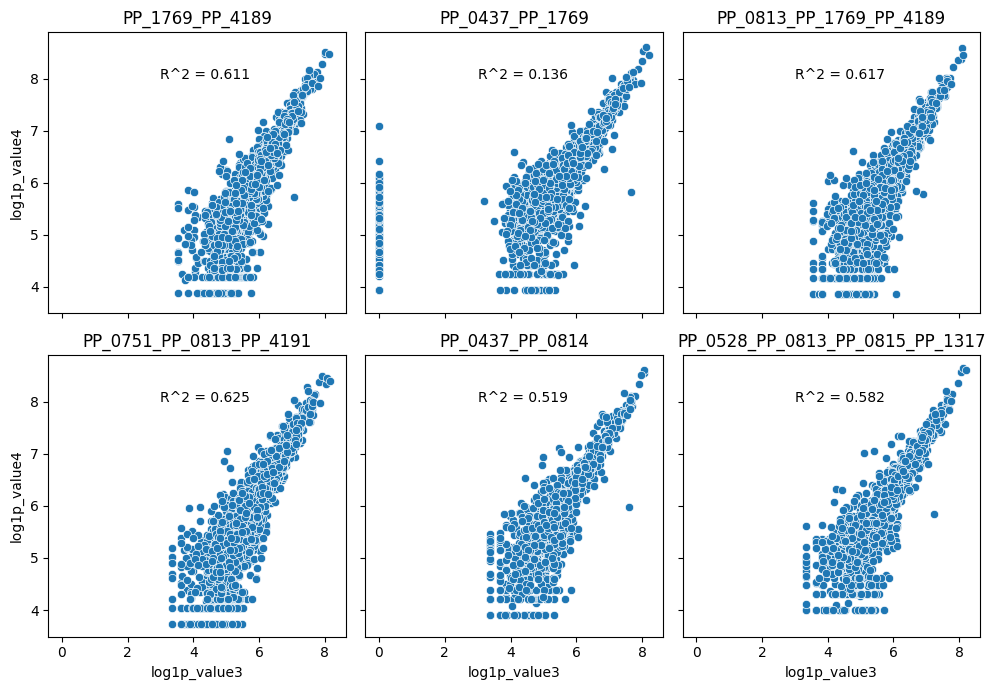

In [17]:
fig, ax = plt.subplots(2,3,figsize = (10,7), sharex = True, sharey = True)
for l, a in zip(list(shared_lines)[:6], fig.get_axes()):
    print(f'line = {l}')
    line_idx = df_merge['line_name'] == l
    sns.scatterplot(
        df_merge.loc[df_merge['line_name']==l, :],
        x = 'log1p_value3',
        y = 'log1p_value4',
        ax = a
    )
    a.set_title(l)
    # a.set(xscale="log", yscale="log")
    r2 = r2_score(np.log10(df_merge.loc[line_idx, 'value3']+1), np.log10(df_merge.loc[line_idx, 'value4']+1))
    a.text(3, 8, f'R^2 = {r2:.3f}')

fig.tight_layout()
    

## Plot dCas9 expression between lines

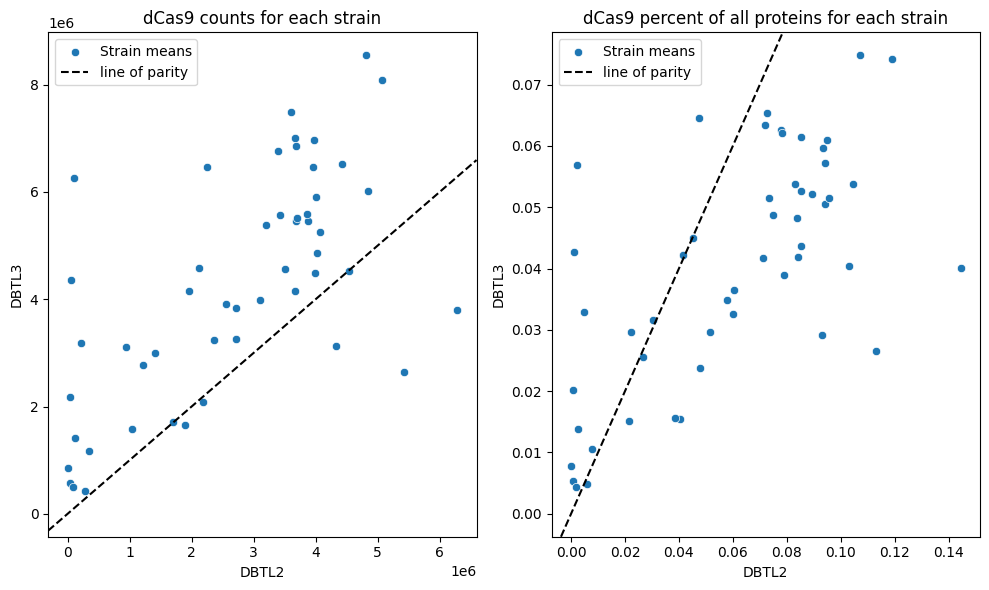

In [18]:
DCAS9_PROTEIN_NAME = 'SPy_1046'
fig, ax = plt.subplots(1,2,figsize = (10,6))
sns.scatterplot(data = df_merge.loc[df_merge['protein'] == DCAS9_PROTEIN_NAME], x = 'value3', y = 'value4', ax = ax[0])
ax[0].axline((0,0), slope=1, color='black', linestyle = '--')
# ax[0].set_aspect('equal')
ax[0].legend(('Strain means', 'line of parity'))
ax[0].set_ylabel('DBTL3')
ax[0].set_xlabel('DBTL2')
ax[0].set_title('dCas9 counts for each strain')

sns.scatterplot(data = df_merge.loc[df_merge['protein'] == DCAS9_PROTEIN_NAME], x = 'pct3', y = 'pct4', ax = ax[1])
ax[1].axline((0,0), slope=1, color='black', linestyle = '--')
# ax[1].set_aspect('equal')
ax[1].legend(('Strain means', 'line of parity'))
ax[1].set_ylabel('DBTL3')
ax[1].set_xlabel('DBTL2')
ax[1].set_title('dCas9 percent of all proteins for each strain')

plt.tight_layout()

Text(0.5, 0, 'log2(Fold change) dCas9 counts: DBTL3/DBTL2')

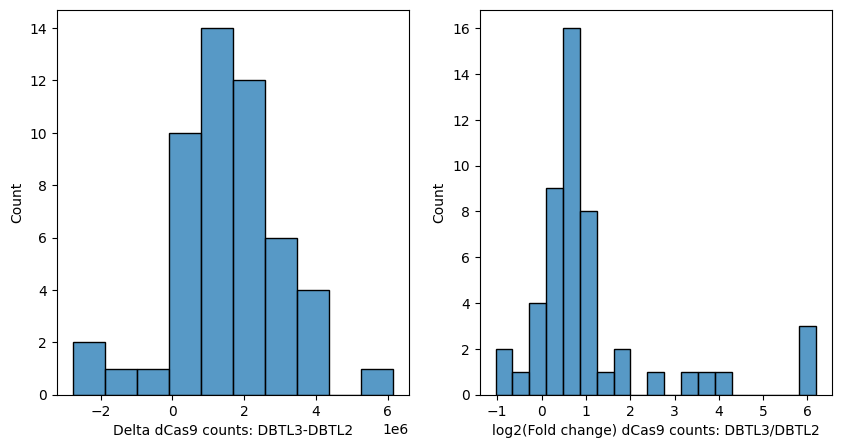

In [19]:
delta_dcas9 = df_merge.loc[df_merge['protein'] == DCAS9_PROTEIN_NAME, 'value4'] - df_merge.loc[df_merge['protein'] == DCAS9_PROTEIN_NAME, 'value3']
foldchange_dcas9 = df_merge.loc[df_merge['protein'] == DCAS9_PROTEIN_NAME, 'value4']/df_merge.loc[df_merge['protein'] == DCAS9_PROTEIN_NAME, 'value3']
fig, ax = plt.subplots(1, 2, figsize = (10,5))
sns.histplot(delta_dcas9, ax = ax[0])
ax[0].set_xlabel('Delta dCas9 counts: DBTL3-DBTL2')
sns.histplot(np.log2(foldchange_dcas9), ax = ax[1])
ax[1].set_xlabel('log2(Fold change) dCas9 counts: DBTL3/DBTL2')


Look at all-protein R2 for each line

In [20]:
line_list =[]
r2_list = []
for i, l in enumerate(shared_lines):
    if l == 'Control':
        control_idx = df_merge['line_name'] == 'Control'
        r2_control = r2_score(df_merge.loc[control_idx, 'log1p_value3'], df_merge.loc[control_idx, 'log1p_value4'])
    else:
        line_idx = df_merge['line_name'] == l
        r2_line = r2_score(df_merge.loc[line_idx, 'log1p_value3'], df_merge.loc[line_idx, 'log1p_value4'])
        r2_list.append(r2_line)
        line_list.append(l)

r2_df = pd.DataFrame.from_dict({'line_name': line_list, 'r2': r2_list})
r2_df.head(3)

,line_name,r2
0,PP_1769_PP_4189,0.611371
1,PP_0437_PP_1769,0.136412
2,PP_0813_PP_1769_PP_4189,0.617161


Get some random correlations to use as a baseline

In [21]:
N_RANDOM_COMBINATIONS = 1000
r2_list_random = []
line1_list_random = []
line2_list_random = []
for i in range(N_RANDOM_COMBINATIONS):
    [line1, line2] = random.sample(line_list, 2)
    line1_list_random.append(line1)
    line2_list_random.append(line2)
    r2 = r2_score(
        df_merge.loc[df_merge['line_name'] == line1, 'log1p_value3'],
        df_merge.loc[df_merge['line_name'] == line2, 'log1p_value4']
    )
    r2_list_random.append(r2)
r2_df_random = pd.DataFrame.from_dict({'line_name1': line1_list_random, 'line_name2': line2_list_random, 'r2': r2_list_random})
r2_df_random.head(3)

,line_name1,line_name2,r2
0,PP_0815_PP_1317_PP_4191,PP_0528_PP_0815_PP_1317_PP_4191,0.583350
1,PP_0751_PP_0814_PP_1769,PP_0437_PP_0814,0.534070
2,PP_0528_PP_0815_PP_1317,PP_0528_PP_0815_PP_4191,0.616015


In [22]:
line2

'PP_0528_PP_0815_PP_1317'

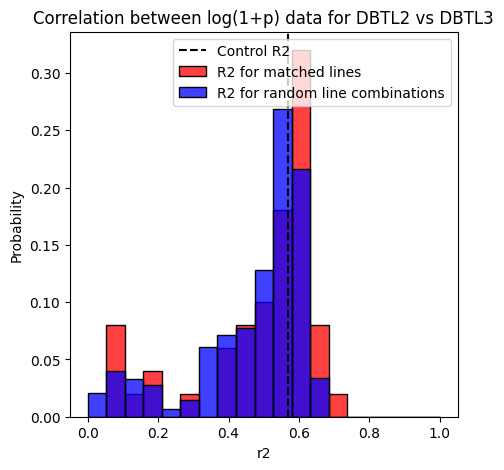

In [23]:
fig, ax = plt.subplots(figsize = (5,5))
bins = np.linspace(0,1, 20)
sns.histplot(data = r2_df, x = 'r2', stat = 'probability', color = 'r', bins = bins)
sns.histplot(data = r2_df_random, x = 'r2', stat='probability', color = 'b', bins = bins)
ax.axvline(r2_control, c = 'k', linestyle = '--')
ax.set_title('Correlation between log(1+p) data for DBTL2 vs DBTL3')
ax.legend(['Control R2', 'R2 for matched lines', 'R2 for random line combinations'])

## Plot titer correlations:

Text(150, 400, 'R2 = 0.186\nMAE = 55.6')

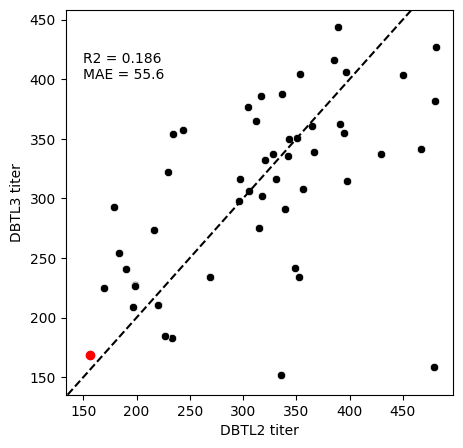

In [24]:
fig, ax = plt.subplots(figsize = (5,5))
sns.scatterplot(data = titer_df_merge, x = 'titer3', y = 'titer4', ax = ax, c = 'k')
ax.scatter(titer_df_merge.loc[titer_df_merge['line_name'] == 'Control', 'titer3'],
           titer_df_merge.loc[titer_df_merge['line_name'] == 'Control', 'titer4'],
           c = 'r')
           
ax.axline((150,150), slope=1, color='black', linestyle = '--')
ax.set_xlabel('DBTL2 titer')
ax.set_ylabel('DBTL3 titer')
titer_r2 = r2_score(titer_df_merge['titer3'], titer_df_merge['titer4'])
titer_mae = mean_absolute_error(titer_df_merge['titer3'], titer_df_merge['titer4'])
ax.text(150, 400, f'R2 = {titer_r2:.3f}\nMAE = {titer_mae:.1f}')


In [25]:
r2_control

0.5689000343192324

## Look for correlation between $\Delta$titer and $\Delta$dCas9
Our operating hypothesis divides cells into two groups (it's probably more of a continuum, but for explanations sake):

In cells that have low dCas9:
1. Changing the dCas9 plasmid should increase dCas9 levels (therefore leading to a larger $\Delta$dCas9) 
2. Increased dCas9 should mean that the gRNA have a large effect on the cell
3. Since these cells are very different between DBTL2 and DBTl3, we should see their titer change (i.e. $\Delta$titer is large)

In cells that have enough dCas9:
1. Changing the dCas9 plasmid may increase dCas9 levels
2. There was already enough dCas9 in DBTl2, the effects of the gRNA shouldn't change that much
3. Since these cells are relatively similar between DBTL2 and DBTl3, we should see lower changes in titer (i.e. $\Delta$titer is small)

This is probably wrong but I can check!!

In [26]:
def get_dcas9_levels(df, measurement_column, line_name, protein_name = DCAS9_PROTEIN_NAME):
    dcas9_values = df.loc[(df['line_name'] == line_name) &
                          (df['protein'] == protein_name),
                          measurement_column].values
    if len(dcas9_values) == 1:
        return dcas9_values[0]
    else:
        print(f'ERROR: multiple matching entries in df (N = {len(dcas9_values)}).')
        return None

In [27]:
titer_dcas9_df = titer_df_merge.copy()
titer_dcas9_df.head(3)

,line_name,measurement,titer3,titer4
0,Control,isoprenol,156.733342,168.831417
1,PP_0368_PP_0528_PP_4191,isoprenol,328.502033,337.627467
2,PP_0368_PP_0812,isoprenol,312.156633,364.611833


In [28]:
r2_df

,line_name,r2
0,PP_1769_PP_4189,0.611371
1,PP_0437_PP_1769,0.136412
2,PP_0813_PP_1769_PP_4189,0.617161
3,PP_0751_PP_0813_PP_4191,0.625216
4,PP_0437_PP_0814,0.518758
5,PP_0528_PP_0813_PP_0815_PP_1317,0.581554
6,PP_0814_PP_2136,0.549845
7,PP_0528_PP_0815_PP_4191,0.610159
8,PP_0815_PP_1317_PP_4191,0.636360
9,PP_1317,0.102166


In [29]:
titer_dcas9_df['cas3'] = titer_dcas9_df.apply(lambda x: get_dcas9_levels(df_merge, measurement_column='value3', line_name=x['line_name']), axis = 1)
titer_dcas9_df['cas4'] = titer_dcas9_df.apply(lambda x: get_dcas9_levels(df_merge, measurement_column='value4', line_name=x['line_name']), axis = 1)
titer_dcas9_df.head(5)

,line_name,measurement,titer3,titer4,cas3,cas4
0,Control,isoprenol,156.733342,168.831417,3.671387e+06,4.161315e+06
1,PP_0368_PP_0528_PP_4191,isoprenol,328.502033,337.627467,2.722448e+06,3.254294e+06
2,PP_0368_PP_0812,isoprenol,312.156633,364.611833,3.952952e+06,6.474019e+06
3,PP_0368_PP_0813,isoprenol,394.424700,355.079267,4.007205e+06,5.900858e+06
4,PP_0368_PP_1769,isoprenol,190.439533,241.181067,3.256120e+04,5.756492e+05


In [30]:
titer_dcas9_df['delta_titer'] = titer_dcas9_df['titer4']-titer_dcas9_df['titer3']
titer_dcas9_df['delta_cas'] = titer_dcas9_df['cas4']-titer_dcas9_df['cas3']
titer_dcas9_df.head(5)

,line_name,measurement,titer3,titer4,cas3,cas4,delta_titer,delta_cas
0,Control,isoprenol,156.733342,168.831417,3.671387e+06,4.161315e+06,12.098075,4.899286e+05
1,PP_0368_PP_0528_PP_4191,isoprenol,328.502033,337.627467,2.722448e+06,3.254294e+06,9.125433,5.318459e+05
2,PP_0368_PP_0812,isoprenol,312.156633,364.611833,3.952952e+06,6.474019e+06,52.455200,2.521067e+06
3,PP_0368_PP_0813,isoprenol,394.424700,355.079267,4.007205e+06,5.900858e+06,-39.345433,1.893653e+06
4,PP_0368_PP_1769,isoprenol,190.439533,241.181067,3.256120e+04,5.756492e+05,50.741533,5.430880e+05


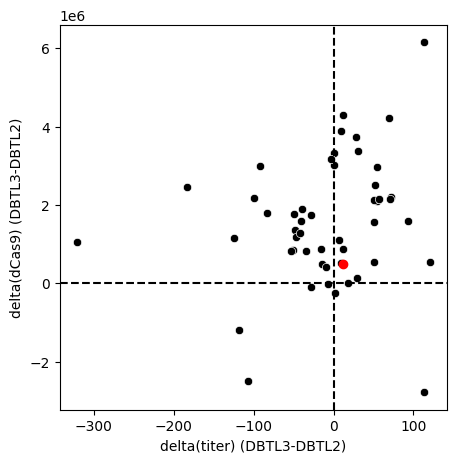

In [31]:
fig, ax = plt.subplots(figsize = (5,5))
sns.scatterplot(data = titer_dcas9_df, x = 'delta_titer', y = 'delta_cas', ax = ax, c= 'k')
ax.scatter(titer_dcas9_df.loc[titer_dcas9_df['line_name'] == 'Control', 'delta_titer'],
           titer_dcas9_df.loc[titer_dcas9_df['line_name'] == 'Control', 'delta_cas'],
           c = 'r')
ax.set_xlabel('delta(titer) (DBTL3-DBTL2)')
ax.set_ylabel('delta(dCas9) (DBTL3-DBTL2)')
ax.axhline(0, c = 'k', linestyle = '--')
ax.axvline(0, c = 'k', linestyle = '--')

## Look at correlation b/w $\Delta$dCas9 and proteomics correlation
We'd expect that strains that didn't change dCas9 levels don't really change their proteome, so the proteomics R2 b/w DBTL2 and DBTl3 should be the same

In [32]:
r2_df.index

RangeIndex(start=0, stop=50, step=1)

In [33]:
titer_dcas9_df['line_name']

0                             Control
1             PP_0368_PP_0528_PP_4191
2                     PP_0368_PP_0812
3                     PP_0368_PP_0813
4                     PP_0368_PP_1769
5                     PP_0368_PP_4189
6             PP_0437_PP_0751_PP_4191
7                     PP_0437_PP_0814
8                     PP_0437_PP_1769
9                     PP_0437_PP_4189
10    PP_0528_PP_0751_PP_0815_PP_1317
11            PP_0528_PP_0751_PP_4191
12            PP_0528_PP_0812_PP_4191
13    PP_0528_PP_0813_PP_0815_PP_1317
14            PP_0528_PP_0813_PP_4191
15    PP_0528_PP_0814_PP_0815_PP_1317
16            PP_0528_PP_0814_PP_4191
17    PP_0528_PP_0815_PP_1317_PP_4191
18            PP_0528_PP_0815_PP_1317
19            PP_0528_PP_0815_PP_4191
20            PP_0528_PP_1769_PP_4191
21            PP_0528_PP_4120_PP_4191
22            PP_0751_PP_0813_PP_4189
23            PP_0751_PP_0813_PP_4191
24                    PP_0751_PP_0813
25            PP_0751_PP_0814_PP_1769
26          

In [34]:
r2_df[r2_df['line_name'] == 'PP_0368_PP_0528_PP_4191']

,line_name,r2
29,PP_0368_PP_0528_PP_4191,0.582965


In [35]:
r2_df

,line_name,r2
0,PP_1769_PP_4189,0.611371
1,PP_0437_PP_1769,0.136412
2,PP_0813_PP_1769_PP_4189,0.617161
3,PP_0751_PP_0813_PP_4191,0.625216
4,PP_0437_PP_0814,0.518758
5,PP_0528_PP_0813_PP_0815_PP_1317,0.581554
6,PP_0814_PP_2136,0.549845
7,PP_0528_PP_0815_PP_4191,0.610159
8,PP_0815_PP_1317_PP_4191,0.636360
9,PP_1317,0.102166


In [36]:
titer_dcas9_df

,line_name,measurement,titer3,titer4,cas3,cas4,delta_titer,delta_cas
0,Control,isoprenol,156.733342,168.831417,3.671387e+06,4.161315e+06,12.098075,4.899286e+05
1,PP_0368_PP_0528_PP_4191,isoprenol,328.502033,337.627467,2.722448e+06,3.254294e+06,9.125433,5.318459e+05
2,PP_0368_PP_0812,isoprenol,312.156633,364.611833,3.952952e+06,6.474019e+06,52.455200,2.521067e+06
3,PP_0368_PP_0813,isoprenol,394.424700,355.079267,4.007205e+06,5.900858e+06,-39.345433,1.893653e+06
4,PP_0368_PP_1769,isoprenol,190.439533,241.181067,3.256120e+04,5.756492e+05,50.741533,5.430880e+05
5,PP_0368_PP_4189,isoprenol,342.346733,335.353533,4.539975e+06,4.526716e+06,-6.993200,-1.325888e+04
6,PP_0437_PP_0751_PP_4191,isoprenol,352.411767,234.237167,4.323851e+06,3.131306e+06,-118.174600,-1.192545e+06
7,PP_0437_PP_0814,isoprenol,305.798300,306.253367,5.078255e+06,8.095636e+06,0.455067,3.017381e+06
8,PP_0437_PP_1769,isoprenol,233.721367,183.288167,0.000000e+00,8.446121e+05,-50.433200,8.446121e+05
9,PP_0437_PP_4189,isoprenol,339.156567,290.934133,2.557095e+06,3.918974e+06,-48.222433,1.361879e+06


In [37]:
r2_df = r2_df.set_index('line_name')
def get_proteomics_r2(line_name):
    if line_name == 'Control':
        return r2_control
    else:
        return r2_df.loc[line_name, 'r2']

titer_dcas9_df['prot_r2'] = titer_dcas9_df['line_name'].apply(lambda x: get_proteomics_r2(x))
titer_dcas9_df.head(3)

,line_name,measurement,titer3,titer4,cas3,cas4,delta_titer,delta_cas,prot_r2
0,Control,isoprenol,156.733342,168.831417,3.671387e+06,4.161315e+06,12.098075,4.899286e+05,0.568900
1,PP_0368_PP_0528_PP_4191,isoprenol,328.502033,337.627467,2.722448e+06,3.254294e+06,9.125433,5.318459e+05,0.582965
2,PP_0368_PP_0812,isoprenol,312.156633,364.611833,3.952952e+06,6.474019e+06,52.455200,2.521067e+06,0.061525


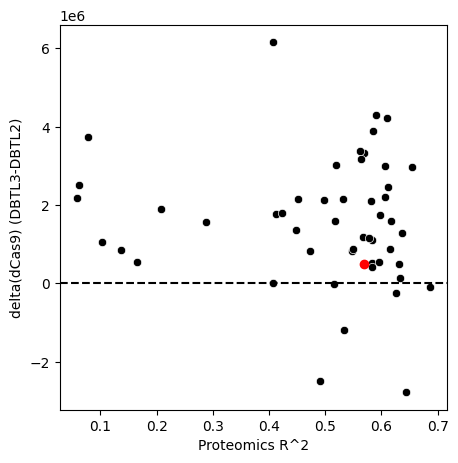

In [38]:
fig, ax = plt.subplots(figsize = (5,5))
sns.scatterplot(data = titer_dcas9_df, x = 'prot_r2', y = 'delta_cas', ax = ax, c= 'k')
ax.scatter(titer_dcas9_df.loc[titer_dcas9_df['line_name'] == 'Control', 'prot_r2'],
           titer_dcas9_df.loc[titer_dcas9_df['line_name'] == 'Control', 'delta_cas'],
           c = 'r')
ax.set_xlabel('Proteomics R^2')
ax.set_ylabel('delta(dCas9) (DBTL3-DBTL2)')
ax.axhline(0, c = 'k', linestyle = '--')
